In [6]:
from __future__ import division
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier

Open dataset

In [7]:
trData = pd.read_csv('Data\cs-training.csv',header = 0).drop('Unnamed: 0',axis=1)
tsData = pd.read_csv('Data\cs-test.csv',header = 0).drop('Unnamed: 0',axis=1)

### Dataset Profile

Check whether dataset is balance or imbalance

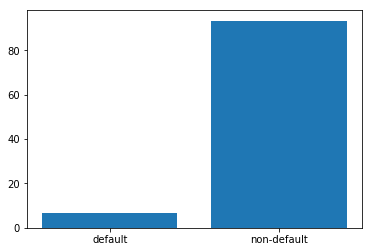

In [8]:
default = trData['SeriousDlqin2yrs'].sum()*100/len(trData)
non_default = (len(trData)-trData['SeriousDlqin2yrs'].sum())*100/len(trData)

x = np.arange(2)
plt.bar(x,[default,non_default])
plt.xticks(x, ('default','non-default'))
plt.show()

Based on this figure, we can conclude that the dataset is imbalanced data

### Outlier Detection

Check if there is any outlier by looking data distribution

In [9]:
def getHistogram(data):
    labels, values = zip(*Counter(data).items())
    indexes = np.arange(len(labels))
    width=1
    plt.bar(indexes,values,width)
    plt.xticks(indexes+width*0.5, labels)
    plt.show()

#### Distribution of NumberOfTime3059DaysPastDueNotWorse (Training Set)

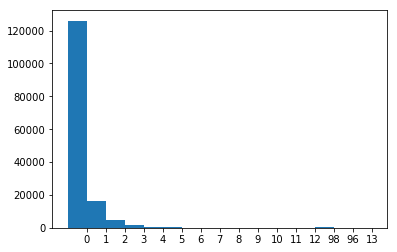

In [10]:
getHistogram(trData.NumberOfTime3059DaysPastDueNotWorse)

#### Distribution of NumberOfTimes90DaysLate (Training Set)

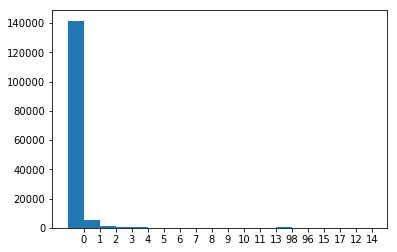

In [11]:
getHistogram(trData.NumberOfTimes90DaysLate)

#### Distribution of NumberOfTime6089DaysPastDueNotWorse (Training Set)

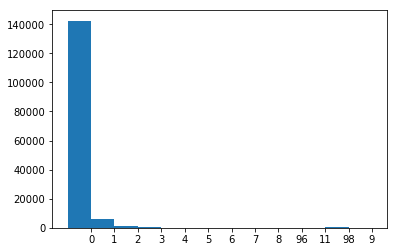

In [13]:
getHistogram(trData.NumberOfTime6089DaysPastDueNotWorse)

#### Distribution of NumberOfTime3059DaysPastDueNotWorse (Testing Set)

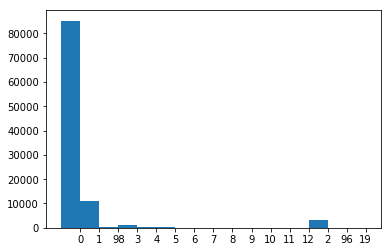

In [14]:
getHistogram(tsData.NumberOfTime3059DaysPastDueNotWorse)

#### Distribution of NumberOfTimes90DaysLate (Training Set)

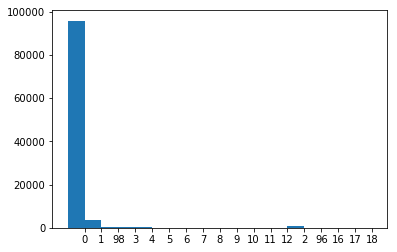

In [15]:
getHistogram(tsData.NumberOfTimes90DaysLate)

#### Distribution of NumberOfTime6089DaysPastDueNotWorse (Training Set)

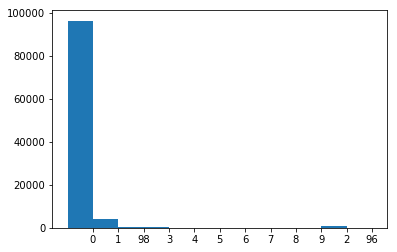

In [16]:
getHistogram(tsData.NumberOfTime6089DaysPastDueNotWorse)

We can see that all of data contain outliers value "96" and 98
Then we will replace this value with median value

In [17]:
def outlier_lateness(datalist):
    new_data = []
    med_data = datalist.median()
    for data in datalist:
        if (data == 96) | (data == 98):
            new_data.append(med_data)
        else:
            new_data.append(data)
    datalist = new_data
    return datalist

In [18]:
trData.NumberOfTime3059DaysPastDueNotWorse = outlier_lateness(trData.NumberOfTime3059DaysPastDueNotWorse)

trData.NumberOfTimes90DaysLate = outlier_lateness(trData.NumberOfTimes90DaysLate)

trData.NumberOfTime6089DaysPastDueNotWorse = outlier_lateness(trData.NumberOfTime6089DaysPastDueNotWorse)

tsData.NumberOfTime3059DaysPastDueNotWorse = outlier_lateness(tsData.NumberOfTime3059DaysPastDueNotWorse)

tsData.NumberOfTimes90DaysLate = outlier_lateness(tsData.NumberOfTimes90DaysLate)

tsData.NumberOfTime6089DaysPastDueNotWorse = outlier_lateness(tsData.NumberOfTime6089DaysPastDueNotWorse)

### Missing Value Imputation

In this dataset, we spotted missing value at "MonthlyIncome" and "NumberOfDependents". Thus, we will impute it with mean value

In [19]:
imputer_mean = Imputer(missing_values = 'NaN',strategy = 'mean')
monthly_income = trData.MonthlyIncome.values
monthly_income = imputer_mean.fit_transform(monthly_income.reshape(-1,1))
trData.MonthlyIncome = monthly_income

monthly_income = tsData.MonthlyIncome.values
monthly_income = imputer_mean.fit_transform(monthly_income.reshape(-1,1))
tsData.MonthlyIncome = monthly_income

number_dependents = trData.NumberOfDependents.values
number_dependents = imputer_mean.fit_transform(number_dependents.reshape(-1,1))
trData.NumberOfDependents = number_dependents

number_dependents = tsData.NumberOfDependents.values
number_dependents = imputer_mean.fit_transform(number_dependents.reshape(-1,1))
tsData.NumberOfDependents = number_dependents

### Feature Extraction 

During data exploration, we found that we can extract more information from given dataset
This information are Debt and Sum of Lateness

#### Debt 

Debt = Monthly Income * Debt Ratio

In [20]:
debt = trData.MonthlyIncome.values * trData.DebtRatio.values
debt = pd.Series(debt)
trData = trData.assign(debt=debt.values)
debt = tsData.MonthlyIncome.values * tsData.DebtRatio.values
debt = pd.Series(debt)
tsData = tsData.assign(debt=debt.values)

#### Sum Of Lateness 

Sum Of Lateness = NumberOfTime3059DaysPastDueNotWorse +  NumberOfTimes90DaysLate + NumberOfTime6089DaysPastDueNotWorse

In [21]:
sum_of_lateness = trData.NumberOfTime3059DaysPastDueNotWorse.values + trData.NumberOfTimes90DaysLate.values + trData.NumberOfTime6089DaysPastDueNotWorse.values
sumOfLateness = pd.Series(sum_of_lateness)
trData = trData.assign(sumOfLateness=sumOfLateness.values)
sum_of_lateness = tsData.NumberOfTime3059DaysPastDueNotWorse.values + tsData.NumberOfTimes90DaysLate.values + tsData.NumberOfTime6089DaysPastDueNotWorse.values
sumOfLateness = pd.Series(sum_of_lateness)
tsData = tsData.assign(sumOfLateness=sumOfLateness.values)

### Benchmarking

we select some classifiers (Random Forest, Gradient Boosting, AdaBoost, Bagging) that can handle imbalance data. Then we do 10-fold cross validation to choose the best classifier

For evaluation metrics, we use AUC score

In [22]:
def do_kFold(clf, X, y): 
    i=0
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    cv = KFold(n_splits = 10)
    for train, test in cv.split(X,y):
        clf.fit(X[train], y[train])
        prob = clf.predict_proba(X[test])
        fpr,tpr, thresholds = roc_curve(y[test], prob[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
X = trData.drop('SeriousDlqin2yrs', axis=1).values
y = trData.SeriousDlqin2yrs.values

#### Random Forest

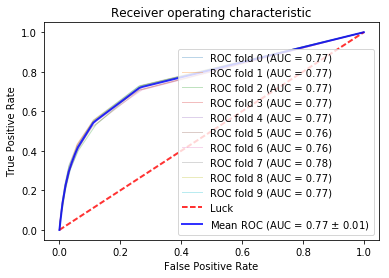

In [31]:
rf = RandomForestClassifier(class_weight = "balanced")
do_kFold(rf, X, y)

#### Gradient Boosting

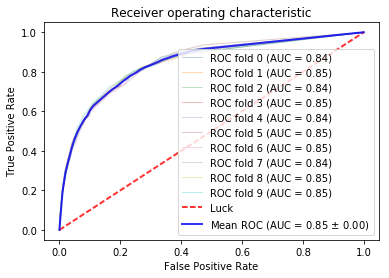

In [25]:
gb = GradientBoostingClassifier(learning_rate=0.01)
do_kFold(gb, X, y)

#### Ada Boost

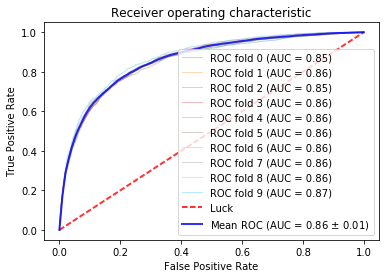

In [26]:
ada = AdaBoostClassifier()
do_kFold(ada, X, y)

#### Bagging

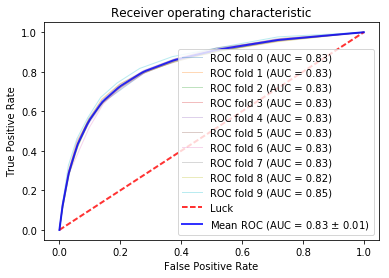

In [27]:
bagging = BalancedBaggingClassifier()
do_kFold(bagging, X, y)

From this benchmarking result, we can see that Ada Boost is the best classifier. Then, we use it to do prediction

In [28]:
ada.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

### Feature Importances 

We want to know which feature plays key role in model performance

Feature ranking:
1. feature 0 (0.300000)
2. feature 11 (0.200000)
3. feature 5 (0.120000)
4. feature 7 (0.100000)
5. feature 1 (0.100000)
6. feature 4 (0.080000)
7. feature 3 (0.040000)
8. feature 10 (0.020000)
9. feature 8 (0.020000)
10. feature 6 (0.020000)
11. feature 9 (0.000000)
12. feature 2 (0.000000)


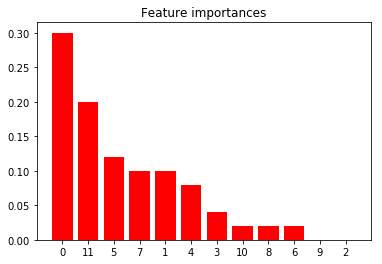

In [29]:
importances = ada.feature_importances_

std = np.std([ada.feature_importances_ for tree in ada.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Based on this result, feature "RevolvingUtilizationOfUnsecuredLines" is the most important feature, followed by new feature "Sum Of Lateness".
Feature Ranking
1. RevolvingUtilizationOfUnsecuredLines
2. Sum Of Lateness
3. NumberOfOpenCreditLinesAndLoans
4. NumberRealEstateLoansOrLines
5. age
6. MonthlyIncome
7. DebtRatio
8. Debt
9. NumberOfTime60-89DaysPastDueNotWorse
10. NumberOfTimes90DaysLate
11. NumberOfDependents
12. NumberOfTime30-59DaysPastDueNotWorse

We can see that summation of lateness give more predictive power than every lateness feature

### Probability of Default Prediction 

In [35]:
X_test = tsData.drop('SeriousDlqin2yrs', axis=1).values
probability_of_default = ada.predict_proba(X_test)